<a href="https://colab.research.google.com/github/pritika-vig/modeling-adrs/blob/main/lstm/contrastive_book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MIMIC-III Embedding Generation Notebook
## Step 1: Install Dependencies
!pip install google-cloud-bigquery torch torchvision torchaudio scikit-learn pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Step 2: Authenticate Google Cloud
from google.colab import auth
auth.authenticate_user()
# Step 3: Query MIMIC-III data
from google.cloud import bigquery
import pandas as pd
import numpy as np
client = bigquery.Client(project="mit-mlhc-class-450518")

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import random
import torch.backends.cudnn as cudnn

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

set_seed(42)


In [ ]:
QUERY_IO = """
WITH long_stays AS (
  SELECT icustay_id, subject_id, hadm_id, intime, outtime
  FROM `physionet-data.mimiciii_clinical.icustays`
  WHERE DATETIME_DIFF(outtime, intime, DAY) >= 4
),
input_events_mv AS (
  SELECT icustay_id, itemid, starttime AS event_time, rate AS amount
  FROM `physionet-data.mimiciii_clinical.inputevents_mv`
  WHERE icustay_id IS NOT NULL AND rate IS NOT NULL
),
input_events_cv AS (
  SELECT icustay_id, itemid, charttime AS event_time, amount
  FROM `physionet-data.mimiciii_clinical.inputevents_cv`
  WHERE icustay_id IS NOT NULL AND amount IS NOT NULL
),
output_events AS (
  SELECT icustay_id, itemid, charttime AS event_time, value AS amount
  FROM `physionet-data.mimiciii_clinical.outputevents`
  WHERE icustay_id IS NOT NULL AND value IS NOT NULL
),
chartevents_subset AS (
  SELECT icustay_id, itemid, charttime AS event_time, valuenum AS amount
  FROM `physionet-data.mimiciii_clinical.chartevents`
  WHERE icustay_id IS NOT NULL
    AND valuenum IS NOT NULL
),
lab_events AS (
  SELECT s.icustay_id, l.itemid, l.charttime AS event_time, l.valuenum AS amount
  FROM `physionet-data.mimiciii_clinical.labevents` l
  JOIN `physionet-data.mimiciii_clinical.icustays` s
    ON l.hadm_id = s.hadm_id AND l.subject_id = s.subject_id
  WHERE l.valuenum IS NOT NULL
),
all_events AS (
  SELECT * FROM input_events_mv
  UNION ALL
  SELECT * FROM input_events_cv
  UNION ALL
  SELECT * FROM output_events
  UNION ALL
  SELECT * FROM chartevents_subset
  UNION ALL
  SELECT * FROM lab_events
),
events_3day AS (
  SELECT e.icustay_id, e.itemid, e.event_time, e.amount, s.intime
  FROM all_events e
  JOIN long_stays s ON e.icustay_id = s.icustay_id
  WHERE e.event_time BETWEEN s.intime AND TIMESTAMP_ADD(s.intime, INTERVAL 3 DAY)
)
SELECT icustay_id, itemid, event_time, amount, intime FROM events_3day
"""

input_output_df = client.query(QUERY_IO).to_dataframe()
print("Event data shape:", input_output_df.shape)

Event data shape: (42241052, 5)


In [ ]:

allergy_terms = ['diphenhydramine', 'cetirizine', 'loratadine', 'hydroxyzine',
                 'fexofenadine', 'chlorpheniramine', 'ranitidine', 'famotidine']

query_d_items = """
SELECT itemid, LOWER(label) AS label
FROM `physionet-data.mimiciii_clinical.d_items`
"""
d_items_df = client.query(query_d_items).to_dataframe()

allergy_itemids = d_items_df[d_items_df['label'].str.contains('|'.join(allergy_terms), na=False)]['itemid'].tolist()
input_output_df = input_output_df[~input_output_df['itemid'].isin(allergy_itemids)]
print("Filtered shape (no allergy meds):", input_output_df.shape)

Filtered shape (no allergy meds): (42240990, 5)


In [ ]:
# Query ADR ICD codes from diagnoses_icd
ADR_ICD9_CODES = set([
    '9950', '9952', 'E850', 'E851', 'E852', 'E853', 'E854', 'E855', 'E856', 'E858', 'E859',
    'E930', 'E931', 'E932', 'E933', 'E934', 'E935', 'E936', 'E937', 'E938', 'E939',
    'E940', 'E941', 'E942', 'E943', 'E944', 'E945', 'E946', 'E947', 'E948', 'E949',
    '9954', '9956', '27669', '36255', '6923', '6930', '7080'
])

QUERY_ADR = """
SELECT di.icustay_id, d.icd9_code
FROM `physionet-data.mimiciii_clinical.diagnoses_icd` d
JOIN `physionet-data.mimiciii_clinical.icustays` di
  ON d.hadm_id = di.hadm_id
"""
adr_df = client.query(QUERY_ADR).to_dataframe()
adr_df['ADR'] = adr_df['icd9_code'].isin(ADR_ICD9_CODES)
adr_labels = adr_df.groupby('icustay_id')['ADR'].max().reset_index()

In [ ]:
# === Filter for valid ICU stays with both events and labels ===
valid_ids = np.intersect1d(adr_labels['icustay_id'].unique(), input_output_df['icustay_id'].unique())
adr_labels = adr_labels[adr_labels['icustay_id'].isin(valid_ids)]
input_output_df = input_output_df[input_output_df['icustay_id'].isin(valid_ids)]

# === Calculate time since ICU admission and bin into hourly slots ===
input_output_df['event_time'] = pd.to_datetime(input_output_df['event_time'])
input_output_df['intime'] = pd.to_datetime(input_output_df['intime'])

input_output_df['hours_since_intime'] = (
    (input_output_df['event_time'] - input_output_df['intime']).dt.total_seconds() / 3600
)
input_output_df = input_output_df[input_output_df['hours_since_intime'].between(0, 72)]
input_output_df['time_bin'] = input_output_df['hours_since_intime'].astype(int).clip(0, 71)

# === Keep top-K most frequent itemids (features) ===
top_itemids = input_output_df['itemid'].value_counts().nlargest(600).index
itemid_to_index = {itemid: idx for idx, itemid in enumerate(sorted(top_itemids))}
input_output_df = input_output_df[input_output_df['itemid'].isin(top_itemids)]
input_output_df['feature_idx'] = input_output_df['itemid'].map(itemid_to_index)

# === Map ICU IDs to row indices ===
icu_ids = sorted(adr_labels['icustay_id'].unique())
icu_id_to_idx = {icu_id: idx for idx, icu_id in enumerate(icu_ids)}
input_output_df['icu_idx'] = input_output_df['icustay_id'].map(icu_id_to_idx)

# === Build (N, T, F) tensor using groupby instead of for-loop ===
grouped = input_output_df.groupby(['icu_idx', 'time_bin', 'feature_idx'])['amount'].sum().reset_index()

# Initialize empty tensor
N, T, F_num = len(icu_ids), 72, len(itemid_to_index)
sequences = np.zeros((N, T, F_num), dtype=np.float32)

# Efficiently populate tensor
sequences[grouped['icu_idx'], grouped['time_bin'], grouped['feature_idx']] = grouped['amount'].values

icu_ids = np.array(icu_ids)
print("sequences shape:", sequences.shape)
print("icu_ids shape:", icu_ids.shape)



sequences shape: (18959, 72, 600)
icu_ids shape: (18959,)


In [ ]:
X.columns

Index(['index', 'cat__gender_F', 'cat__gender_M',
       'cat__admission_type_ELECTIVE', 'cat__admission_type_EMERGENCY',
       'cat__admission_type_NEWBORN', 'cat__admission_type_URGENT',
       'remainder__icustay_id', 'remainder__age',
       'remainder__has_drug_allergy_history',
       ...
       'remainder__Drain Out #1 Jackson Pratt_y',
       'remainder__Chest Tubes CTICU CT 1_y', 'remainder__Chest Tubes Other_y',
       'remainder__Ultrafiltrate Ultrafiltrate_y',
       'remainder__Urine Out Suprapubic_y',
       'remainder__Chest Tubes CTICU CT 2_y', 'remainder__Protonix gtt_y',
       'remainder__Urine ._y', 'remainder__cerebral drain right_y',
       'remainder__NA Acetate/H2O_y'],
      dtype='object', length=430)

In [ ]:
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
file_path = '/content/drive/My Drive/physionet/adr_features_with_subclass_labels.csv'
df = pd.read_csv(file_path)
print("Loaded data:", df.shape)
# Feature matrix
X = df.drop(columns=[
'subject_id', 'hadm_id', 'window_start', 'window_end', 'ADR', 'ethnicity',
] + [col for col in df.columns if col.startswith('ADR_ICD_')])
X.columns
X.isna().any(axis=1).sum()
# Identify categorical and numeric columns
print(X.columns)
categorical_cols = ['gender', 'admission_type']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Leave the numeric columns untouched
)

# Apply preprocessing
X = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X = pd.DataFrame(X, columns=feature_names)
X.columns = [col.replace('remainder__', '') for col in X.columns]
X = X.reset_index()

Loaded data: (17277, 438)
Index(['icustay_id', 'gender', 'age', 'admission_type',
       'has_drug_allergy_history', 'ICD_9671', 'ICD_9604', 'ICD_9390',
       'ICD_9672', 'ICD_3995',
       ...
       'Drain Out #1 Jackson Pratt_y', 'Chest Tubes CTICU CT 1_y',
       'Chest Tubes Other_y', 'Ultrafiltrate Ultrafiltrate_y',
       'Urine Out Suprapubic_y', 'Chest Tubes CTICU CT 2_y', 'Protonix gtt_y',
       'Urine ._y', 'cerebral drain right_y', 'NA Acetate/H2O_y'],
      dtype='object', length=425)


In [ ]:
X.columns

Index(['index', 'cat__gender_F', 'cat__gender_M',
       'cat__admission_type_ELECTIVE', 'cat__admission_type_EMERGENCY',
       'cat__admission_type_NEWBORN', 'cat__admission_type_URGENT',
       'icustay_id', 'age', 'has_drug_allergy_history',
       ...
       'Drain Out #1 Jackson Pratt_y', 'Chest Tubes CTICU CT 1_y',
       'Chest Tubes Other_y', 'Ultrafiltrate Ultrafiltrate_y',
       'Urine Out Suprapubic_y', 'Chest Tubes CTICU CT 2_y', 'Protonix gtt_y',
       'Urine ._y', 'cerebral drain right_y', 'NA Acetate/H2O_y'],
      dtype='object', length=430)

In [ ]:
def augment_embeddings_with_features(embeddings, icustay_ids, extra_features_df):
    """
    Given LSTM embeddings and corresponding icustay_ids, merge with external features.

    Args:
        embeddings (np.ndarray): Embeddings from LSTM, shape (n_samples, embedding_dim)
        icustay_ids (np.ndarray): Array of icustay_id matching each embedding
        extra_features_df (pd.DataFrame): DataFrame with `icustay_id` and additional features

    Returns:
        np.ndarray: Augmented embeddings with extra features
    """
    # Convert embeddings to DataFrame and include icustay_id for merging
    emb_df = pd.DataFrame(embeddings)
    emb_df['icustay_id'] = icustay_ids

    # Merge with external features on icustay_id
    merged = emb_df.merge(extra_features_df, on='icustay_id', how='left')

    # Drop icustay_id after merging
    augmented = merged.drop(columns=['icustay_id'])

    # Ensure no NaNs remain (you may want to use imputation instead)
    if augmented.isnull().any().any():
        print("Warning: NaNs detected in augmented data. Consider handling them properly.")
        augmented = augmented.fillna(0)

    return augmented.values


In [ ]:
class LSTMTripletEmbedder(nn.Module):
    def __init__(self, input_size, hidden_size=64, projection_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.projection = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, projection_dim)
        )
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return F.normalize(self.projection(hn.squeeze(0)), dim=1)

class TripletDataset(Dataset):
    def __init__(self, sequences, labels, p_positive_anchor=0.5):
        self.sequences = sequences
        self.labels = np.array(labels)
        self.label_to_indices = {
            int(label): np.where(self.labels == label)[0].tolist()
            for label in np.unique(self.labels)
        }
        self.p_positive_anchor = p_positive_anchor

    def __getitem__(self, _):
        if np.random.rand() < self.p_positive_anchor and len(self.label_to_indices[1]) > 1:
            anchor_label = 1
        else:
            anchor_label = 0

        anchor_idx = np.random.choice(self.label_to_indices[anchor_label])
        pos_idx = anchor_idx
        while pos_idx == anchor_idx:
            pos_idx = np.random.choice(self.label_to_indices[anchor_label])
        neg_label = 1 - anchor_label
        neg_idx = np.random.choice(self.label_to_indices[neg_label])

        return (
            torch.tensor(self.sequences[anchor_idx], dtype=torch.float32),
            torch.tensor(self.sequences[pos_idx], dtype=torch.float32),
            torch.tensor(self.sequences[neg_idx], dtype=torch.float32)
        )

    def __len__(self):
        return len(self.sequences)



In [ ]:
def train_triplet_model(
    model,
    train_dataset,
    val_data,
    val_labels,
    device='cuda',
    epochs=50,
    batch_size=64,
    lr=1e-3,
    margin=0.5,
    patience=5,
    verbose=True,
):
    from torch.utils.data import DataLoader
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = lambda a, p, n: F.relu(F.pairwise_distance(a, p) - F.pairwise_distance(a, n) + margin).mean()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TripletDataset(val_data, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    best_loss = float('inf')
    counter = 0
    best_state = None
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            emb_a = model(anchor)
            emb_p = model(positive)
            emb_n = model(negative)

            loss = loss_fn(emb_a, emb_p, emb_n)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        # Proper validation triplet loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for anchor, positive, negative in val_loader:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
                emb_a = model(anchor)
                emb_p = model(positive)
                emb_n = model(negative)
                val_loss += loss_fn(emb_a, emb_p, emb_n).item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if verbose:
            print(f"Epoch {epoch+1}: train loss = {avg_train_loss:.4f}, val loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                if verbose:
                    print("Early stopping triggered.")
                break
    if best_state:
        model.load_state_dict(best_state)

    # Optional: plot training and validation loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Triplet Loss")
    plt.title("Triplet Loss Over Epochs (Train vs Val)")
    plt.grid(True)
    plt.legend()
    plt.show()

    return model




--- Fold 1 ---
Epoch 1: train loss = 0.3056, val loss = 0.4647
Epoch 2: train loss = 0.1637, val loss = 0.5143
Epoch 3: train loss = 0.1118, val loss = 0.5336
Epoch 4: train loss = 0.0808, val loss = 0.5474
Epoch 5: train loss = 0.0717, val loss = 0.5525
Epoch 6: train loss = 0.0744, val loss = 0.5436
Early stopping triggered.


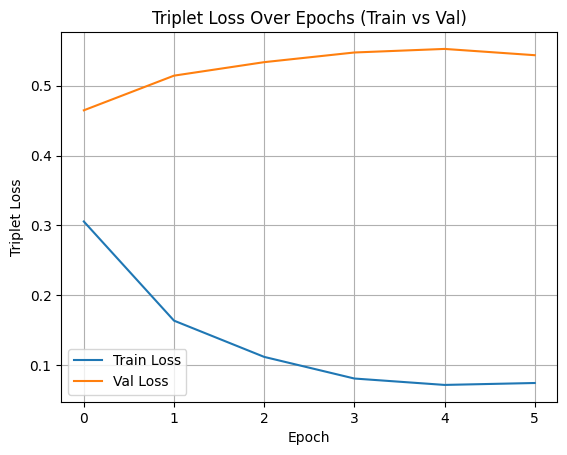

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:51:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


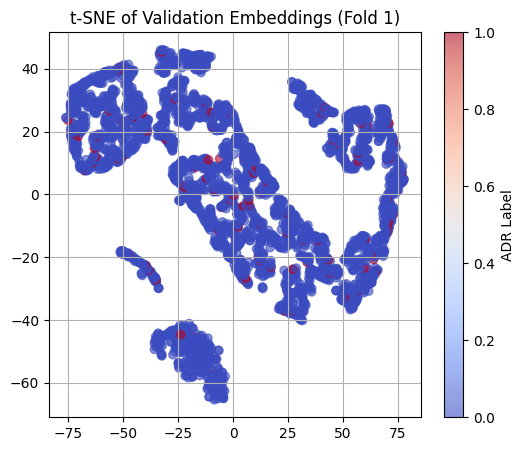


--- Fold 2 ---
Epoch 1: train loss = 0.2867, val loss = 0.4977
Epoch 2: train loss = 0.1358, val loss = 0.5214
Epoch 3: train loss = 0.0951, val loss = 0.5498
Epoch 4: train loss = 0.0742, val loss = 0.5393
Epoch 5: train loss = 0.0624, val loss = 0.5608
Epoch 6: train loss = 0.0525, val loss = 0.5518
Early stopping triggered.


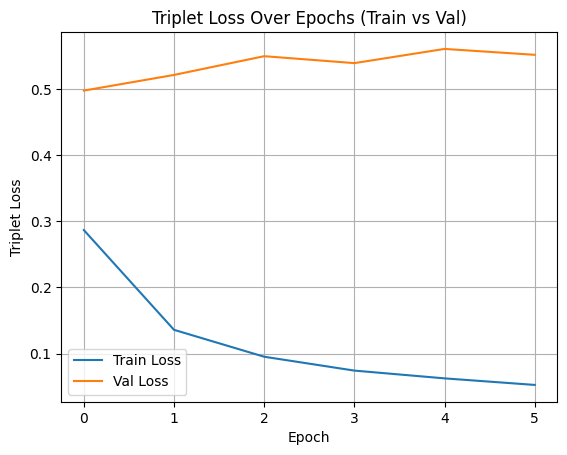

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:53:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


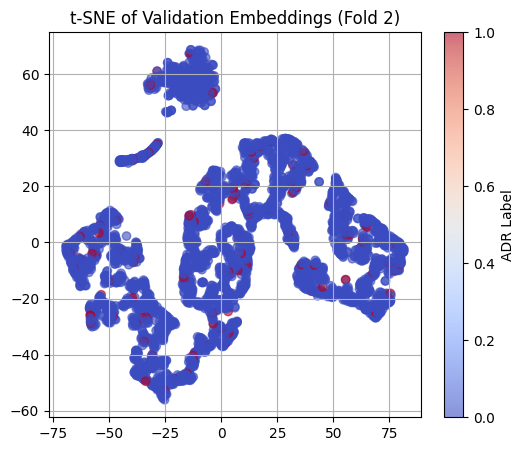


--- Fold 3 ---
Epoch 1: train loss = 0.3078, val loss = 0.4892
Epoch 2: train loss = 0.1510, val loss = 0.5410
Epoch 3: train loss = 0.1129, val loss = 0.5427
Epoch 4: train loss = 0.0931, val loss = 0.5431
Epoch 5: train loss = 0.0784, val loss = 0.5598
Epoch 6: train loss = 0.0635, val loss = 0.5500
Early stopping triggered.


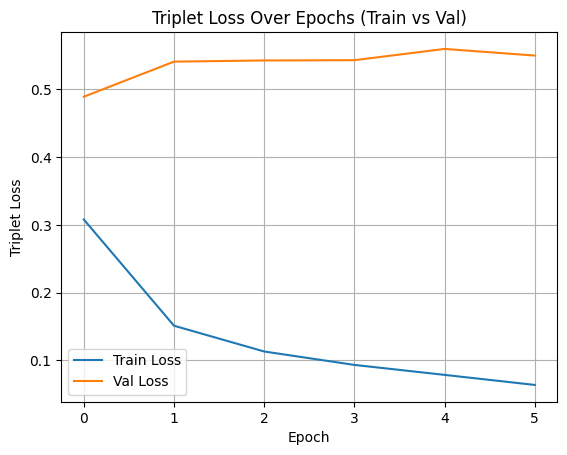

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


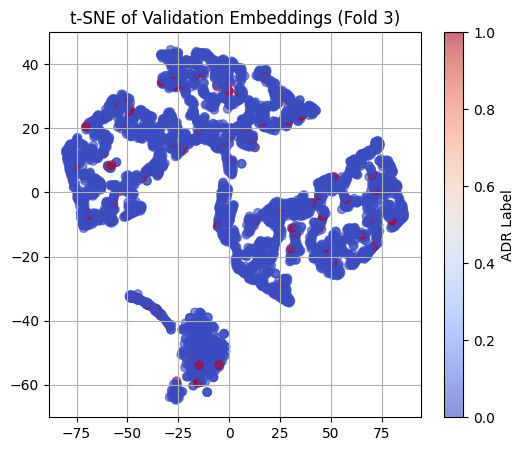


--- Fold 4 ---
Epoch 1: train loss = 0.2975, val loss = 0.5100
Epoch 2: train loss = 0.1577, val loss = 0.5240
Epoch 3: train loss = 0.1057, val loss = 0.5281
Epoch 4: train loss = 0.0848, val loss = 0.5314
Epoch 5: train loss = 0.0778, val loss = 0.5517
Epoch 6: train loss = 0.0685, val loss = 0.5524
Early stopping triggered.


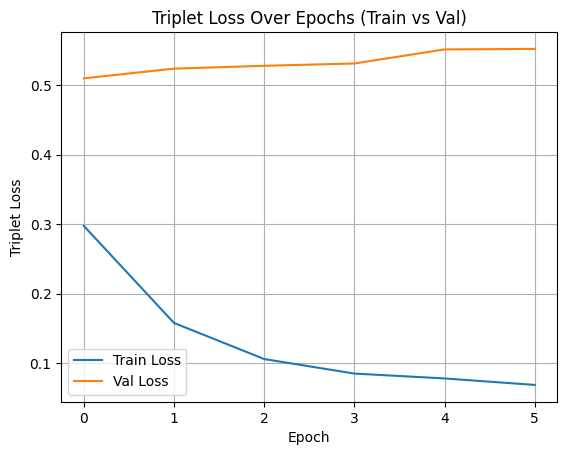

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:58:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


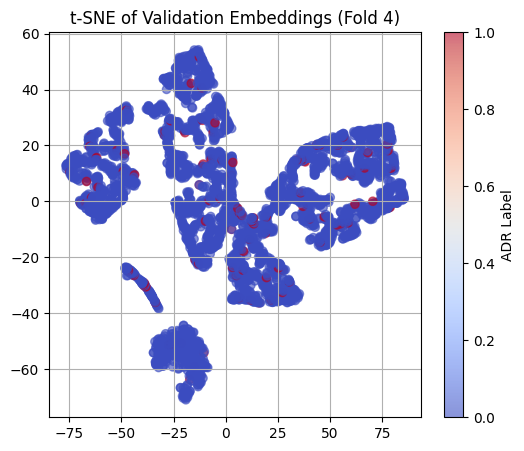


--- Fold 5 ---
Epoch 1: train loss = 0.3172, val loss = 0.4943
Epoch 2: train loss = 0.1543, val loss = 0.5427
Epoch 3: train loss = 0.1103, val loss = 0.5607
Epoch 4: train loss = 0.0881, val loss = 0.5481
Epoch 5: train loss = 0.0764, val loss = 0.5383
Epoch 6: train loss = 0.0627, val loss = 0.5417
Early stopping triggered.


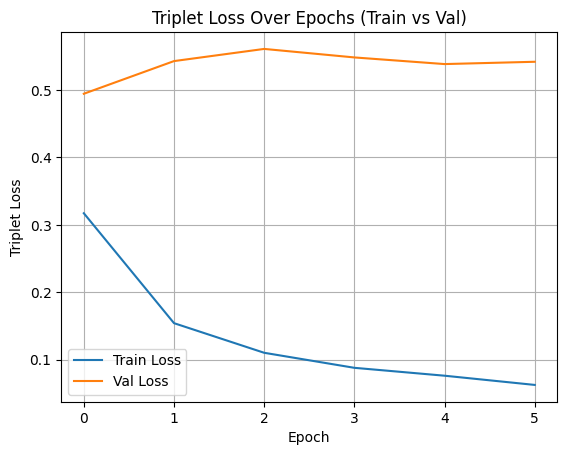

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:01:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


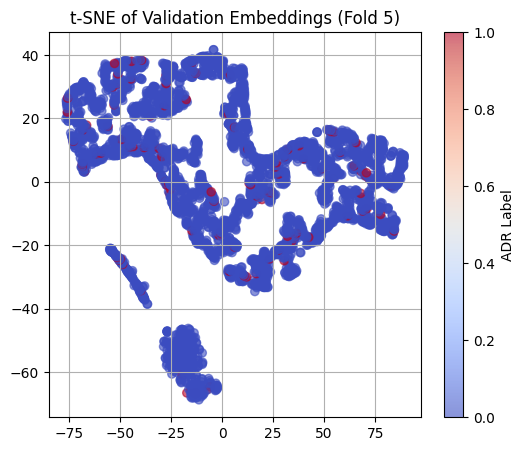

In [ ]:
from imblearn.combine import SMOTETomek
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels = adr_labels.set_index('icustay_id').reindex(icu_ids).fillna(0).astype(int).values
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_preds = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(kf.split(sequences, labels)):
    print(f"\n--- Fold {fold+1} ---")

    x_train, x_val = sequences[train_idx], sequences[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Train LSTM embedder with triplet loss
    model = LSTMTripletEmbedder(input_size=x_train.shape[2])
    train_dataset = TripletDataset(x_train, y_train, p_positive_anchor=0.75)
    val_dataset = TripletDataset(x_val, y_val)
    model = train_triplet_model(model, train_dataset, x_val, y_val, device=device, epochs=50, patience=5)

    # Extract embeddings
    def extract_embeddings(model, data):
        model.eval()
        with torch.no_grad():
            tensor = torch.tensor(data, dtype=torch.float32).to(device)
            return model(tensor).cpu().numpy()

    emb_train = extract_embeddings(model, x_train)
    emb_val = extract_embeddings(model, x_val)

    train_ids = np.array(icu_ids)[train_idx]
    val_ids = np.array(icu_ids)[val_idx]

    # ✅ Augment embeddings with external features
    X_train_aug = augment_embeddings_with_features(emb_train, train_ids, X)
    X_val_aug = augment_embeddings_with_features(emb_val, val_ids, X)

    # 🔄 Apply SMOTETomek in the embedding space
    smt = SMOTETomek(sampling_strategy=.1, random_state=42)
    X_train_bal, y_train_bal = smt.fit_resample(X_train_aug, y_train)

    # XGBoost classification
    # Train XGBoost on resampled embeddings
    clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    clf.fit(X_train_bal, y_train_bal)
    probs = clf.predict_proba(X_val_aug)[:, 1]
    all_preds.extend(probs)
    all_true.extend(y_val)


    # t-SNE Visualization
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(X_val_aug)
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=y_val, cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label='ADR Label')
    plt.title(f't-SNE of Validation Embeddings (Fold {fold+1})')
    plt.grid(True)
    plt.show()


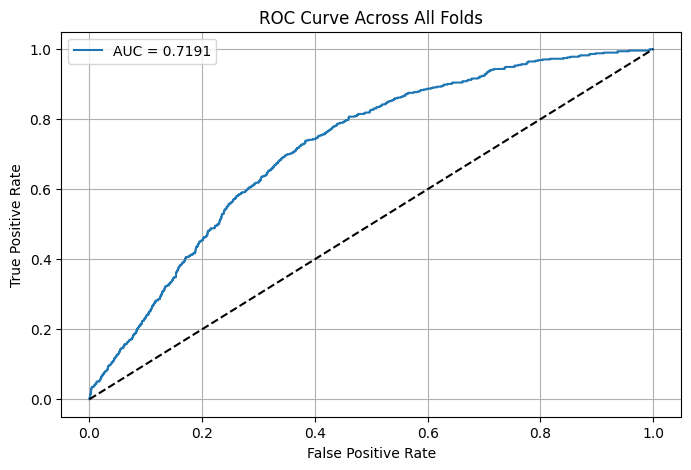

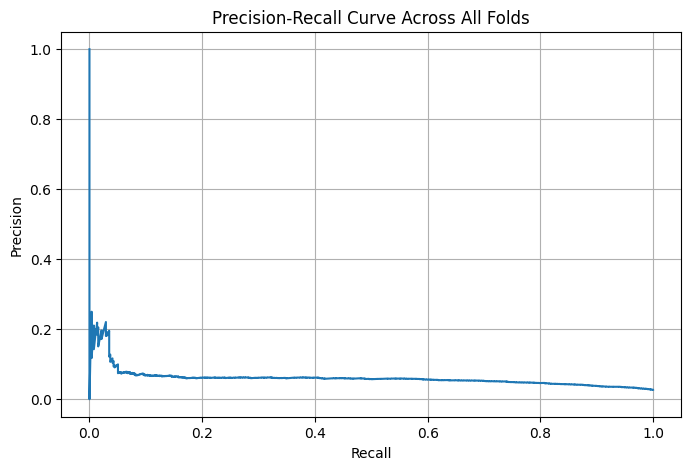

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(all_true, all_preds)
roc_auc = roc_auc_score(all_true, all_preds)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Across All Folds")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_true, all_preds)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Across All Folds")
plt.grid(True)
plt.show()
